# 98-sat-image-analysis-polygon Script for debugging

This notebook is a simplified version of script 22-sat_image_analysis-polygon.py (Updated up until April 25 2024).
It allows us to __run an area of interest__ and 1 resolution in order to spot and debug errors.

This notebook helped create __raster>arrange_items()__

## Import libraries

In [7]:
from pystac_client import Client
from pystac.extensions.eo import EOExtension as eo
import planetary_computer as pc
import geopandas as gpd
import h3
import pandas as pd

import rasterio
from rasterio import windows
from rasterio import features
from rasterio import warp
import rasterio.mask
from rasterio.enums import Resampling
from rasterio.merge import merge

import numpy as np
from PIL import Image

import matplotlib.pyplot as plt

from shapely.geometry import Point

from tqdm import tqdm

import os
import sys
module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

## Config notebook

In [8]:
# Sat is not sentinel-2-l2a, it is landsat-c2-l2:
# https://github.com/microsoft/PlanetaryComputerExamples/blob/main/datasets/landsat-8-c2-l2/landsat-8-c2-l2-example.ipynb

# Set raster spectral bands and analysis equation
band_name_dict = {'nir':[False], #If GSD(resolution) of band is different, set True.
                  'red':[False], #If GSD(resolution) of band is different, set True.
                  'eq':['(nir-red)/(nir+red)']}

# Set analysis name
index_analysis = 'ndvi'

# Set directory to save analysed rasters
tmp_dir = f'../../data/processed/tmp_{index_analysis}/'

# Set desired hex resolution
res = [8] #JUST ONE since it is for trials, if many needed use script or edit notebook

# Set frequency of search for rasters (MS = Month Start)
freq = 'MS'

# Set start and end date for search (Sentinel-2 2A has images since mids 2015)
start_date = '2019-01-01'
end_date = '2023-12-31'

# Set satellite. Defaults to "sentinel-2-l2a", also "landsat-c2-l2" available.
satellite = "sentinel-2-l2a"

#Set filter if necessary. Defaults to "{}". Example: No images with cloud cover avobe 10%: {"eo:cloud_cover": {"lt": 10}}
sat_query = {"eo:cloud_cover": {"lt": 30}} #'plataform':{'in':['landsat-8','landsat-9']}

# Del rasters after processing.
del_data = False # True

# Save?
local_save = False #------ Set True if test
save = False #------ Set True if full analysis

# city can be substituted by "place". (presa_laboca / presa_cerroprieto / presa_elcuchillo)
city = 'medellin'

## 01 - Load Area of interest

<Axes: >

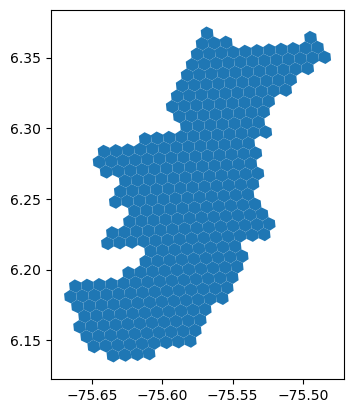

In [3]:
#Load data
aoi_original = gpd.read_file("../../data/external/temporal_todocker/colombia/medellin_urban_gcs.geojson")

### Create city area of interest with biggest hexs
big_res = min(res)
poly = aoi_original.to_crs("EPSG:32618").buffer(500).reset_index()
poly = poly.rename(columns={0:'geometry'})
poly = gpd.GeoDataFrame(poly, geometry='geometry')
poly = poly.to_crs("EPSG:4326")
hex_city = aup.create_hexgrid(poly, big_res)

# Show
hex_city.plot()

## 02 - Download and process rasters

In [12]:
### Download and process rasters
df_len = aup.download_raster_from_pc(hex_city, index_analysis, city, freq, 
                                     start_date, end_date, tmp_dir, band_name_dict, 
                                     query = sat_query, satellite = satellite)

/opt/conda/envs/gds/lib/python3.9/site-packages/pystac_client/item_search.py:835: FutureWarning: get_items() is deprecated, use items() instead
  warnings.warn(


ValueError: Cannot set a DataFrame with multiple columns to the single column month

### 02 Finding problem in download_raster_from_pc

Debugging function __From raster.py: def download_raster_from_pc__(gdf, index_analysis, city, freq, start_date, end_date, tmp_dir, band_name_dict, query={}, satellite="sentinel-2-l2a")

In [6]:
# Assign Notebook data to function's arguments that have a different name inside function
gdf = hex_city.copy()
query = sat_query

In [13]:
# create area of interest coordinates from hexagons to download raster data    
print('Extracting bounding coordinates from hexagons')
# Create buffer around hexagons
poly = gdf.to_crs("EPSG:3857").buffer(500)
poly = poly.to_crs("EPSG:4326")
poly = gpd.GeoDataFrame(geometry=poly).dissolve().geometry

# Extracts coordinates from polygon as DataFrame
coord_val = poly.bounds
# Gets coordinates for bounding box
n = coord_val.maxy.max()
s = coord_val.miny.min()
e = coord_val.maxx.max()
w = coord_val.minx.min()

# Sets the coordinates for the area of interest
area_of_interest = {
    "type": "Polygon",
    "coordinates": [
        [
            [e, s],
            [w, s],
            [w, n],
            [e, n],
            [e, s],
        ]
    ],
}

# create time of interest
print('Defining time of interest')
time_of_interest = aup.create_time_of_interest(start_date, end_date, freq=freq)

# gathers items for time and area of interest
print('Gathering items for time and area of interest')
items = aup.gather_items(time_of_interest, area_of_interest, query=query, satellite=satellite)
print(f'Fetched {len(items)} items')

date_list = aup.available_datasets(items, satellite)

# create dictionary from links
band_name_list = list(band_name_dict.keys())[:-1]
assets_hrefs = aup.link_dict(band_name_list, items, date_list)
print('Created dictionary from items')

Extracting bounding coordinates from hexagons
Defining time of interest
Gathering items for time and area of interest


/opt/conda/envs/gds/lib/python3.9/site-packages/pystac_client/item_search.py:835: FutureWarning: get_items() is deprecated, use items() instead
  warnings.warn(


Fetched 40 items
Created dictionary from items


__Fetched 0 items?__

In [8]:
items

[<Item id=LC08_L2SP_009056_20190717_02_T1>,
 <Item id=LC08_L2SP_009055_20190717_02_T1>,
 <Item id=LC08_L2SP_009056_20190903_02_T1>,
 <Item id=LC08_L2SP_009055_20190903_02_T1>,
 <Item id=LC08_L2SP_009056_20191224_02_T1>]

__Why?__

#items = aup.gather_items(time_of_interest, area_of_interest, query=query, satellite=satellite)

* __time_of_interest__ looks ok (Compared it to presa_elbosque, looks similar)
* __area_of_interest__ looks ok (Ploted it, it is a bounding box enclosing the aoi)
* __query might be the problem__
* __satellite__ don't know (Haven't used this satellite)

In [15]:
query_2 = {}
items = aup.gather_items(time_of_interest, area_of_interest, query=query_2, satellite=satellite)
items

[<Item id=LE07_L2SP_009056_20190130_02_T1>,
 <Item id=LC08_L2SP_009056_20190122_02_T1>,
 <Item id=LC08_L2SP_009055_20190122_02_T1>,
 <Item id=LE07_L2SP_009056_20190114_02_T2>,
 <Item id=LC08_L2SP_009056_20190106_02_T1>,
 <Item id=LC08_L2SP_009055_20190106_02_T1>,
 <Item id=LC08_L2SP_009056_20190223_02_T1>,
 <Item id=LC08_L2SP_009055_20190223_02_T1>,
 <Item id=LE07_L2SP_009056_20190215_02_T1>,
 <Item id=LC08_L2SP_009056_20190207_02_T1>,
 <Item id=LC08_L2SP_009055_20190207_02_T1>,
 <Item id=LC08_L2SP_009056_20190327_02_T1>,
 <Item id=LC08_L2SP_009055_20190327_02_T1>,
 <Item id=LE07_L2SP_009056_20190319_02_T2>,
 <Item id=LC08_L2SP_009056_20190311_02_T1>,
 <Item id=LC08_L2SP_009055_20190311_02_T1>,
 <Item id=LE07_L2SP_009056_20190303_02_T1>,
 <Item id=LC08_L2SP_009056_20190428_02_T1>,
 <Item id=LC08_L2SP_009055_20190428_02_T1>,
 <Item id=LE07_L2SP_009056_20190420_02_T1>,
 <Item id=LC08_L2SP_009056_20190412_02_T1>,
 <Item id=LC08_L2SP_009055_20190412_02_T1>,
 <Item id=LE07_L2SP_009056_20190

In [20]:
items[0].datetime.date()
items[0].properties['landsat:wrs_row']

'056'

### 02b Trying debugging download_raster_from_pc without query

In [22]:
# Assign Notebook data to function's arguments that have a different name inside function
gdf = hex_city.copy()
query = {}

In [23]:
# create area of interest coordinates from hexagons to download raster data    
print('Extracting bounding coordinates from hexagons')
# Create buffer around hexagons
poly = gdf.to_crs("EPSG:6372").buffer(500)
poly = poly.to_crs("EPSG:4326")
poly = gpd.GeoDataFrame(geometry=poly).dissolve().geometry

# Extracts coordinates from polygon as DataFrame
coord_val = poly.bounds
# Gets coordinates for bounding box
n = coord_val.maxy.max()
s = coord_val.miny.min()
e = coord_val.maxx.max()
w = coord_val.minx.min()

# Sets the coordinates for the area of interest
area_of_interest = {
    "type": "Polygon",
    "coordinates": [
        [
            [e, s],
            [w, s],
            [w, n],
            [e, n],
            [e, s],
        ]
    ],
}

# create time of interest
print('Defining time of interest')
time_of_interest = aup.create_time_of_interest(start_date, end_date, freq=freq)

# gathers items for time and area of interest
print('Gathering items for time and area of interest')
items = aup.gather_items(time_of_interest, area_of_interest, query=query, satellite=satellite)
print(f'Fetched {len(items)} items')

date_list = aup.available_datasets(items, satellite)

# create dictionary from links
band_name_list = list(band_name_dict.keys())[:-1]
assets_hrefs = aup.link_dict(band_name_list, items, date_list)
print('Created dictionary from items')

Extracting bounding coordinates from hexagons
Defining time of interest
Gathering items for time and area of interest


/opt/conda/envs/gds/lib/python3.9/site-packages/pystac_client/item_search.py:835: FutureWarning: get_items() is deprecated, use items() instead
  warnings.warn(


Fetched 408 items
Created dictionary from items


__Good, there are items__

In [24]:
# analyze available data according to raster properties
df_len, missing_months = aup.df_date_links(assets_hrefs, start_date, end_date, band_name_list, freq)

ValueError: Cannot set a DataFrame with multiple columns to the single column month

__Did not work, that's another issue.__

#### 02b) 1. Debugging df_date_links

Debugging function __From raster.py: def df_date_links__(assets_hrefs, start_date, end_date, band_name_list, freq='MS')

In [25]:
# dictionary to dataframe
df_dates = pd.DataFrame.from_dict(assets_hrefs, orient='Index').reset_index().rename(columns={'index':'date'})
#df_dates['date'] = pd.to_datetime(df_dates['date']).dt.date
#df_dates['year'] = df_dates.apply(lambda row: row['date'].year, axis=1)
#df_dates['month'] = df_dates.apply(lambda row: row['date'].month, axis=1)
df_dates

,date


__Identified problem: df_dates is an empty DataFrame__

In [26]:
#df_dates = pd.DataFrame.from_dict(assets_hrefs, orient='Index').reset_index().rename(columns={'index':'date'})
assets_hrefs

{}

__Identified problem: assets_hrefs is empty__

In [27]:
#assets_hrefs = aup.link_dict(band_name_list, items, date_list)
date_list

[]

__Identified problem: date_list is empty__

In [28]:
date_list = aup.available_datasets(items, satellite)
date_list

[]

__All arguments in available_datasets exist, there's a problem inside function.__

#### 02b) 2. Debugging available_datasets

Debugging function __From raster.py: def available_datasets__(items, satellite="sentinel-2-l2a", min_cloud_value=10) __before a modification made to adress too many cloudy images__

In [29]:
def my_available_datasets(items,satellite,min_cloud_value = 10):
    # test raster outliers by date    
    date_dict = {}
    
    date_dict = {}
    # iterate over raster tiles by date
    for i in items:
        if satellite == "sentinel-2-l2a":
            no = """
            # check and add raster properties to dictionary by tile and date
            # if date is within dictionary append properties from item to list
            if i.datetime.date() in list(date_dict.keys()):
                # gather cloud percentage, high_proba_clouds_percentage, no_data values and nodata_pixel_percentage
                # check if properties are within dictionary date keys
                if i.properties['s2:mgrs_tile']+'_cloud' in list(date_dict[i.datetime.date()].keys()):
                    date_dict[i.datetime.date()].update(
                        {i.properties['s2:mgrs_tile']+'_cloud':
                        i.properties['s2:high_proba_clouds_percentage']})
                    #date_dict[i.datetime.date()].update(
                    #    {i.properties['s2:mgrs_tile']+'_nodata':
                    #    i.properties['s2:nodata_pixel_percentage']})
                
                else:
                    date_dict[i.datetime.date()].update(
                        {i.properties['s2:mgrs_tile']+'_cloud':
                        i.properties['s2:high_proba_clouds_percentage']})
                    #date_dict[i.datetime.date()].update(
                    #    {i.properties['s2:mgrs_tile']+'_nodata':
                    #    i.properties['s2:nodata_pixel_percentage']})
            # create new date key and add properties to it
            else:
                date_dict[i.datetime.date()] = {}
                date_dict[i.datetime.date()].update(
                    {i.properties['s2:mgrs_tile']+'_cloud':
                    i.properties['s2:high_proba_clouds_percentage']})
                #date_dict[i.datetime.date()].update(
                #    {i.properties['s2:mgrs_tile']+'_nodata':
                #    i.properties['s2:nodata_pixel_percentage']})
                """
        elif satellite == "landsat-c2-l2":
            # check and add raster properties to dictionary by tile and date
            # if date is within dictionary append properties from item to list
            if i.datetime.date() in list(date_dict.keys()):
                # gather cloud percentage, high_proba_clouds_percentage, no_data values and nodata_pixel_percentage
                # check if properties are within dictionary date keys
                if i.properties['landsat:wrs_row']+'_cloud' in list(date_dict[i.datetime.date()].keys()):
                    date_dict[i.datetime.date()].update(
                        {i.properties['landsat:wrs_row']+'_cloud':
                        i.properties['landsat:cloud_cover_land']})
                
                else:
                    date_dict[i.datetime.date()].update(
                        {i.properties['landsat:wrs_row']+'_cloud':
                        i.properties['landsat:cloud_cover_land']})
            # create new date key and add properties to it
            else:
                date_dict[i.datetime.date()] = {}
                date_dict[i.datetime.date()].update(
                    {i.properties['landsat:wrs_row']+'_cloud':
                    i.properties['landsat:cloud_cover_land']})
    
    # determine third quartile for each tile
    df_tile = pd.DataFrame.from_dict(date_dict, orient='index')
    q3 = [np.percentile(df_tile[c].dropna(),[75]) for c in df_tile.columns.to_list() if 'cloud' in c]
    q3 = [v[0] for v in q3]
    
    # check if q3 analysis is necessary
    q3_test = [True if test>min_cloud_value else False for test in q3]
    if sum(q3_test)>0:
        print(f'Quantile filter dictionary by column: {dict(zip(df_tile.columns, q3))}')
    
        column_list = df_tile.columns.to_list()
    
        # filter dates by missing values or outliers according to cloud and no_data values
        for c in range(len(column_list)):
            df_tile.loc[df_tile[column_list[c]]>q3[c],column_list[c]] = np.nan
    else:
        print('Fixed filter applied')
        column_list = df_tile.columns.to_list()
    
        # filter dates by missing values or outliers according to cloud and no_data values
        for c in range(len(column_list)):
            df_tile.loc[df_tile[column_list[c]]>min_cloud_value,column_list[c]] = np.nan
    
    # arrange by cloud coverage average
    df_tile['avg_cloud'] = df_tile.mean(axis=1)
    df_tile = df_tile.sort_values(by='avg_cloud')
    
    # create list of dates within normal distribution and without missing values
    date_list = df_tile.dropna().index.to_list()
    
    print(f'Available dates: {len(date_list)}')
    print(f'Raster tiles per date: {len(df_tile.columns.to_list())}')

    return date_list

In [30]:
date_list = my_available_datasets(items,satellite)
date_list

Quantile filter dictionary by column: {'056_cloud': 86.5075, '055_cloud': 80.88}
Available dates: 101
Raster tiles per date: 3


[datetime.date(2020, 1, 9),
 datetime.date(2023, 7, 20),
 datetime.date(2020, 2, 10),
 datetime.date(2023, 8, 5),
 datetime.date(2019, 7, 17),
 datetime.date(2022, 7, 9),
 datetime.date(2023, 6, 18),
 datetime.date(2023, 9, 6),
 datetime.date(2019, 9, 3),
 datetime.date(2023, 2, 2),
 datetime.date(2021, 12, 13),
 datetime.date(2021, 5, 19),
 datetime.date(2022, 3, 11),
 datetime.date(2023, 12, 11),
 datetime.date(2022, 7, 8),
 datetime.date(2023, 7, 12),
 datetime.date(2023, 1, 25),
 datetime.date(2020, 7, 19),
 datetime.date(2023, 12, 5),
 datetime.date(2020, 9, 5),
 datetime.date(2022, 5, 22),
 datetime.date(2023, 8, 19),
 datetime.date(2019, 1, 22),
 datetime.date(2023, 9, 22),
 datetime.date(2023, 12, 3),
 datetime.date(2023, 5, 1),
 datetime.date(2023, 9, 30),
 datetime.date(2020, 12, 10),
 datetime.date(2023, 3, 22),
 datetime.date(2022, 1, 30),
 datetime.date(2022, 2, 23),
 datetime.date(2020, 10, 23),
 datetime.date(2019, 12, 24),
 datetime.date(2020, 8, 4),
 datetime.date(2023

__The fact that this works proves that the error was changing this function__

Following cell works on developing a function that substitutes available_datasets in order to avoid the cloud filtering and leave only the tile check.

### Creating function arrange_items()

In [82]:
# Assign Notebook data to function's arguments that have a different name inside function
start_date = '2019-01-01'
end_date = '2019-12-31'
gdf = hex_city.copy()
query = sat_query

In [83]:
# create area of interest coordinates from hexagons to download raster data    
print('Extracting bounding coordinates from hexagons')
# Create buffer around hexagons
poly = gdf.to_crs("EPSG:3857").buffer(500)
poly = poly.to_crs("EPSG:4326")
poly = gpd.GeoDataFrame(geometry=poly).dissolve().geometry

# Extracts coordinates from polygon as DataFrame
coord_val = poly.bounds
# Gets coordinates for bounding box
n = coord_val.maxy.max()
s = coord_val.miny.min()
e = coord_val.maxx.max()
w = coord_val.minx.min()

# Sets the coordinates for the area of interest
area_of_interest = {
    "type": "Polygon",
    "coordinates": [
        [
            [e, s],
            [w, s],
            [w, n],
            [e, n],
            [e, s],
        ]
    ],
}

# create time of interest
print('Defining time of interest')
time_of_interest = aup.create_time_of_interest(start_date, end_date, freq=freq)

# gathers items for time and area of interest
print('Gathering items for time and area of interest')
items = aup.gather_items(time_of_interest, area_of_interest, query=query, satellite=satellite)
print(f'Fetched {len(items)} items')

# FUNCTION TO SUSTITUTE:
#date_list = aup.available_datasets(items, satellite)

Extracting bounding coordinates from hexagons
Defining time of interest
Gathering items for time and area of interest


/opt/conda/envs/gds/lib/python3.9/site-packages/pystac_client/item_search.py:835: FutureWarning: get_items() is deprecated, use items() instead
  warnings.warn(


Fetched 5 items


In [84]:
items

[<Item id=LC08_L2SP_009056_20190717_02_T1>,
 <Item id=LC08_L2SP_009055_20190717_02_T1>,
 <Item id=LC08_L2SP_009056_20190903_02_T1>,
 <Item id=LC08_L2SP_009055_20190903_02_T1>,
 <Item id=LC08_L2SP_009056_20191224_02_T1>]

In [85]:
def arrange_items(items, satellite="sentinel-2-l2a"):
    """
    Previously function available_datasets. 
    Filters for dates where all tiles (rasters) that compose the area of interest are available.

    Arguments:
        items (np.array): items intersecting time and area of interest
        satellite (str): satellite used to download imagery

    Returns:
        date_list (list): List of dates with full image available
    """
    # test raster outliers by date    
    date_dict = {}

    # iterate over raster tiles by date
    for i in items:
        # check and add raster properties (ID to identify tiles and cloud coverage to order dates by cloud coverage) to dictionary by tile and date 
        # (items have different depending on satellite)
        
        # General explanation: date_dict[current date].update({current tile ID : current tile cloud coverage})
        
        if satellite == "sentinel-2-l2a":
            if i.datetime.date() in list(date_dict.keys()):
                # if date already exists in date_dict, update
                date_dict[i.datetime.date()].update({i.properties['s2:mgrs_tile']:i.properties['s2:high_proba_clouds_percentage']})
            else:
                # else, create and update
                date_dict[i.datetime.date()] = {}
                date_dict[i.datetime.date()].update({i.properties['s2:mgrs_tile']:i.properties['s2:high_proba_clouds_percentage']})

        elif satellite == "landsat-c2-l2":
            if i.datetime.date() in list(date_dict.keys()):
                # if date already exists in date_dict, update
                date_dict[i.datetime.date()].update({i.properties['landsat:wrs_row']:i.properties['landsat:cloud_cover_land']})
            else:
                 # else, create and update
                date_dict[i.datetime.date()] = {}
                date_dict[i.datetime.date()].update({i.properties['landsat:wrs_row']:i.properties['landsat:cloud_cover_land']})
                
    # Turn into DataFrame
    df_tile = pd.DataFrame.from_dict(date_dict, orient='index')

    # Drop rows where there are NaNs (Unavailable raster tiles)
    df_tile = df_tile.dropna()

    # Arrange by cloud coverage average
    df_tile['avg_cloud'] = df_tile.mean(axis=1)
    df_tile = df_tile.sort_values(by='avg_cloud')
    
    # Create list of dates
    date_list = df_tile.index.to_list()
    
    return df_tile,date_list

In [86]:
df_clouds, date_list = arrange_items(items, satellite)
date_list

[datetime.date(2019, 7, 17), datetime.date(2019, 9, 3)]

In [87]:
df_clouds

,056,055,avg_cloud
2019-07-17,23.59,3.79,13.690
2019-09-03,23.18,23.23,23.205


In [90]:
df_clouds['avg_cloud'].mean()

18.447499999999998

### Testing download_raster_from_pc with function arrange_items()

In [17]:
# Set raster spectral bands and analysis equation
band_name_dict = {'nir':[False], #If GSD(resolution) of band is different, set True.
                  'red':[False], #If GSD(resolution) of band is different, set True.
                  'eq':['(nir-red)/(nir+red)']}

# Assign Notebook data to function's arguments that have a different name inside function
start_date = '2019-01-01'
end_date = '2023-12-31'
gdf = hex_city.copy()
satellite = "sentinel-2-l2a"
query = {"eo:cloud_cover": {"lt": 28}}

In [18]:
# create area of interest coordinates from hexagons to download raster data    
print('Extracting bounding coordinates from hexagons')
# Create buffer around hexagons
poly = gdf.to_crs("EPSG:3857").buffer(500)
poly = poly.to_crs("EPSG:4326")
poly = gpd.GeoDataFrame(geometry=poly).dissolve().geometry

# Extracts coordinates from polygon as DataFrame
coord_val = poly.bounds
# Gets coordinates for bounding box
n = coord_val.maxy.max()
s = coord_val.miny.min()
e = coord_val.maxx.max()
w = coord_val.minx.min()

# Sets the coordinates for the area of interest
area_of_interest = {
    "type": "Polygon",
    "coordinates": [
        [
            [e, s],
            [w, s],
            [w, n],
            [e, n],
            [e, s],
        ]
    ],
}

# create time of interest
print('Defining time of interest')
time_of_interest = aup.create_time_of_interest(start_date, end_date, freq=freq)

# gathers items for time and area of interest
print('Gathering items for time and area of interest')
items = aup.gather_items(time_of_interest, area_of_interest, query=query, satellite=satellite)
print(f'Fetched {len(items)} items')

# SUBSTITUTED FUNCTION
#date_list = aup.available_datasets(items, satellite)
print('Checking available tiles for area of interest')
df_clouds, date_list = aup.arrange_items(items, satellite)
print(f"{len(date_list)} dates available with avg {round(df_clouds['avg_cloud'].mean(),2)}% clouds.")

# create dictionary from links
band_name_list = list(band_name_dict.keys())[:-1]
assets_hrefs = aup.link_dict(band_name_list, items, date_list)
print('Created dictionary from items')

# analyze available data according to raster properties
df_len, missing_months = aup.df_date_links(assets_hrefs, start_date, end_date, band_name_list, freq)

aup.available_data_check(df_len, missing_months) # test for missing months

# creates raster and analyzes percentage of missing data points
df_len, missing_months = aup.df_date_links(assets_hrefs, start_date, end_date, band_name_list, freq)

pct_missing = round(missing_months/len(df_len),2)*100
# if more than 50% of data is missing, raise error and print message
if pct_missing >= 50:
    
    raise AvailableData('Missing more than 50 percent of data points')

# raster cropping with bounding box from earlier 
bounding_box = gpd.GeoDataFrame(geometry=poly).envelope
gdf_bb = gpd.GeoDataFrame(gpd.GeoSeries(bounding_box), columns=['geometry'])
print('Created bounding box for raster cropping')

# create GeoDataFrame to test nan values in raster
gdf_raster_test = gdf.to_crs("EPSG:3857").buffer(1)
gdf_raster_test = gdf_raster_test.to_crs("EPSG:4326")
gdf_raster_test = gpd.GeoDataFrame(geometry=gdf_raster_test).dissolve()

# raster creation
print('Starting raster creation for specified time')

Extracting bounding coordinates from hexagons
Defining time of interest
Gathering items for time and area of interest


/opt/conda/envs/gds/lib/python3.9/site-packages/pystac_client/item_search.py:835: FutureWarning: get_items() is deprecated, use items() instead
  warnings.warn(


Fetched 196 items
Checking available tiles for area of interest
63 dates available with avg 8.31% clouds.
Created dictionary from items
Created bounding box for raster cropping
Starting raster creation for specified time


In [29]:
# Cantidad de meses disponibles
test = df_clouds.reset_index()
test['date'] = test['index'].apply(lambda x: x.strftime('%Y-%m'))
len(test.date.unique())

32

# After debugging and finding adecuate query

In [39]:
sat_query = {'eo:cloud_cover': {'lt': 28}}

In [ ]:
### Download and process rasters
df_len = aup.download_raster_from_pc(hex_city, index_analysis, city, freq, 
                                     start_date, end_date, tmp_dir, band_name_dict, 
                                     query = sat_query, satellite = satellite)

/opt/conda/envs/gds/lib/python3.9/site-packages/pystac_client/item_search.py:835: FutureWarning: get_items() is deprecated, use items() instead
  warnings.warn(
  0%|                                                                                                                                                                                         | 0/60 [00:00<?, ?it/s]/opt/conda/envs/gds/lib/python3.9/site-packages/pystac_client/item_search.py:835: FutureWarning: get_items() is deprecated, use items() instead
  warnings.warn(


# Other

##### Checking __area_of_interest (Looks fine)__

In [46]:
area_of_interest

{'type': 'Polygon',
 'coordinates': [[[-75.47555550135057, 6.129918955716568],
   [-75.6743478975215, 6.129918955716568],
   [-75.6743478975215, 6.3764123571357185],
   [-75.47555550135057, 6.3764123571357185],
   [-75.47555550135057, 6.129918955716568]]]}

In [55]:
from shapely.geometry import Polygon

polygon_geom = Polygon(area_of_interest['coordinates'][0])
polygon_gdf = gpd.GeoDataFrame(index=[0], crs='epsg:4326', geometry=[polygon_geom])

<Axes: >

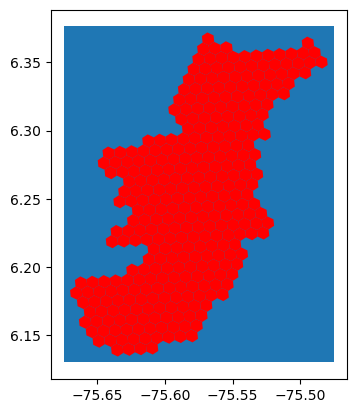

In [58]:
fig, ax = plt.subplots()
polygon_gdf.plot(ax=ax,zorder=0)
hex_city.plot(ax=ax,zorder=1,color='red')

##### Checking __query (Is different to other sats, do not know)__

In [12]:
query = {'plataform': {'in': ['landsat-8', 'landsat-9']}}
items = aup.gather_items(time_of_interest, area_of_interest, query=query, satellite=satellite)
items

/opt/conda/envs/gds/lib/python3.9/site-packages/pystac_client/item_search.py:835: FutureWarning: get_items() is deprecated, use items() instead
  warnings.warn(


[]

In [13]:
#query = {'plataform': {'in': ['landsat-8', 'landsat-9']}}
items = aup.gather_items(time_of_interest, area_of_interest, query=query, satellite=satellite)
items

[]

##### Checking __satellite (Is different to other sats, do not know)__

In [61]:
satellite

'landsat-c2-l2'

# After debugging

In [11]:
# analyze available data according to raster properties
df_len, missing_months = aup.df_date_links(assets_hrefs, start_date, end_date, band_name_list, freq)
aup.available_data_check(df_len, missing_months) # test for missing months

# creates raster and analyzes percentage of missing data points
df_len, missing_months = aup.df_date_links(assets_hrefs, start_date, end_date, band_name_list, freq)
pct_missing = round(missing_months/len(df_len),2)*100

# if more than 50% of data is missing, raise error and print message
if pct_missing >= 50:

    raise AvailableData('Missing more than 50 percent of data points')

# raster cropping with bounding box from earlier 
bounding_box = gpd.GeoDataFrame(geometry=poly).envelope
gdf_bb = gpd.GeoDataFrame(gpd.GeoSeries(bounding_box), columns=['geometry'])
print('Created bounding box for raster cropping')

# create GeoDataFrame to test nan values in raster
gdf_raster_test = gdf.to_crs("EPSG:6372").buffer(1)
gdf_raster_test = gdf_raster_test.to_crs("EPSG:4326")
gdf_raster_test = gpd.GeoDataFrame(geometry=gdf_raster_test).dissolve()

ValueError: Cannot set a DataFrame with multiple columns to the single column month

In [ ]:
# raster creation
print('Starting raster creation for specified time')
# download raster data by month
#create_raster_by_month(df_len, index_analysis, city, tmp_dir, 
#                       band_name_dict, date_list, gdf_raster_test, gdf_bb, 
#                       aoi, sat, query={}, time_exc_limit=1500)

df_len = aup.create_raster_by_month(df_len, index_analysis, city, tmp_dir,
                                    band_name_dict, date_list, gdf_raster_test,
                                    gdf_bb, area_of_interest, satellite, query=query)
print('Finished raster creation')

Starting raster creation for specified time


  0%|                                                                                         | 0/60 [00:00<?, ?it/s]/opt/conda/envs/gds/lib/python3.9/site-packages/pystac_client/item_search.py:835: FutureWarning: get_items() is deprecated, use items() instead
  warnings.warn(


## 03 - Create hexgrids

In [ ]:
# Create res_list
res_list=[]
for r in range(res[0],res[-1]+1):
    res_list.append(r)

# Load hexgrids
hex_gdf = hex_city.copy()
hex_gdf.rename(columns={f'hex_id_8':'hex_id'}, inplace=True)
hex_gdf['res'] = 8

print(f'Loaded hexgrid res 8')

for r in res_list:
    # biggest resolution already loaded
    if r == 8:
        continue
    # Load hexgrid
    table_hex = f'hexgrid_{r}_city_2020'
    query = f"SELECT hex_id_{r},geometry FROM {schema_hex}.{table_hex} WHERE (ST_Intersects(geometry, \'SRID=4326;{poly_wkt}\'))"
    hex_tmp = aup.gdf_from_query(query, geometry_col='geometry')
    # Format hexgrid
    hex_tmp.rename(columns={f'hex_id_{r}':'hex_id'}, inplace=True)
    hex_tmp['res'] = r
    # Concatenate to hex_gdf
    hex_gdf = pd.concat([hex_gdf, hex_tmp])

    print(f'Loaded hexgrid res {r}')

    del hex_tmp

In [ ]:
# NOT IN SCRIPT - Since this notebook allows us to run trials it keeps 1 resolution specified in res
hex_gdf = hex_gdf.loc[hex_gdf.res == res[0]]
hex_gdf.res.unique()

## 04 - Process and save data

In [ ]:
def raster_to_hex_save(hex_gdf_i, df_len, index_analysis, tmp_dir, city, r, save, i=0):
    print(f'Translating raster to hexagon for res: {r}')
    
    hex_raster_analysis, df_raster_analysis = aup.raster_to_hex_analysis(hex_gdf_i, df_len, index_analysis,
                                                                tmp_dir, city, r)
    print('Finished assigning raster data to hexagons')
    print(f'df nan values: {df_raster_analysis[index_analysis].isna().sum()}')
    if df_raster_analysis[index_analysis].isna().sum() > 0:
        raise NanValues('NaN values are still present after processing')
    
    # local save (test)
    if local_save:
        # Create folder to store local save
        localsave_dir = tmp_dir+'local_save/'
        if os.path.exists(localsave_dir) == False:
            os.mkdir(localsave_dir)
    
        # Local save
        hex_raster_analysis.to_file(tmp_dir+'local_save/'+f'{city}_{index_analysis}_HexRes{r}_v{i}.geojson')
        df_raster_analysis.to_csv(tmp_dir+'local_save/'+f'{city}_{index_analysis}_HexRes{r}_v{i}.csv')

    # Save - upload to database
    if save:
        upload_chunk = 150000
        print(f'Starting upload for res: {r}')

        if r == 8:
            # df upload
            aup.df_to_db_slow(df_raster_analysis, f'{index_analysis}_complete_dataset_hex',
                            'raster_analysis', if_exists='append', chunksize=upload_chunk)
            # gdf upload
            aup.gdf_to_db_slow(hex_raster_analysis, f'{index_analysis}_analysis_hex',
                            'raster_analysis', if_exists='append')

        else:
            # df upload
            limit_len = 5000000
            if len(df_raster_analysis)>limit_len:
                c_upload = len(df_raster_analysis)/limit_len
                for k in range(int(c_upload)+1):
                    print(f"Starting range k = {k} of {int(c_upload)}")
                    df_inter_upload = df_raster_analysis.iloc[int(limit_len*k):int(limit_len*(1+k))].copy()
                    aup.df_to_db(df_inter_upload,f'{index_analysis}_complete_dataset_hex',
                                    'raster_analysis', if_exists='append')
            else:
                aup.df_to_db(df_raster_analysis,f'{index_analysis}_complete_dataset_hex',
                                    'raster_analysis', if_exists='append')
            # gdf upload
            aup.gdf_to_db_slow(hex_raster_analysis, f'{index_analysis}_analysis_hex',
                            'raster_analysis', if_exists='append')
        print(f'Finished uploading data for res{r}')
        
    # delete variables
    del df_raster_analysis
    del hex_raster_analysis

In [ ]:
for r in list(hex_gdf.res.unique()):

    print(f'---------------------------------------')
    print(f'STARTING processing for resolution {r}.')

    processing_chunk = 100000

    # filters hexagons at specified resolution
    hex_gdf_res = hex_gdf.loc[hex_gdf.res==r].copy()
    hex_gdf_res = hex_gdf_res.reset_index(drop=True)

    if len(hex_gdf_res)>processing_chunk:
        print(f'hex_gdf_res len: {len(hex_gdf_res)} is bigger than processing chunk: {processing_chunk}')
        c_processing = len(hex_gdf_res)/processing_chunk
        print(f'There are {round(c_processing)} processes')
        for i in range(int(c_processing)+1):
            print(f'Processing from {i*processing_chunk} to {(i+1)*processing_chunk}')
            hex_gdf_i = hex_gdf_res.iloc[int(processing_chunk*i):int(processing_chunk*(1+i))].copy()
            raster_to_hex_save(hex_gdf_i, df_len, index_analysis, tmp_dir, city, r, save, i)

    else:
        print('hex_gdf len smaller than processing chunk')
        hex_gdf_i = hex_gdf_res.copy()
        raster_to_hex_save(hex_gdf_i, df_len, index_analysis, tmp_dir, city, r, save)

print(f'Finished processing city -- {city}')
del hex_gdf

if del_data:
    # delete raster files
    aup.delete_files_from_folder(tmp_dir)